# Tutorial: Reproducing Trajectories & Scenario Projection

In [1]:
import yaml
from epymodelingsuite.config_loader import load_basemodel_config_from_file, load_sampling_config_from_file, load_calibration_config_from_file

from epymodelingsuite.dispatcher.builder import dispatch_builder, make_scenario_projection_simulate_wrappers
from epymodelingsuite.dispatcher.runner import dispatch_runner
from epymodelingsuite.schema.calibration import reproduce_trajectory, reproduce_all_trajectories
from epymodelingsuite.builders.orchestrators import make_simulate_wrapper
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd


### Load YAML

In [8]:
calibration_config = load_calibration_config_from_file("data/flu_round05_modelset_calibration.yml")
basemodel_config = load_basemodel_config_from_file("data/flu_round05_basemodel_calibration.yml")

In [9]:
calibrators = dispatch_builder(
    basemodel_config=basemodel_config,
    sampling_config=None,
    calibration_config=calibration_config
)

In [10]:
cal_res = dispatch_runner(calibrators[0])

Starting ABC-SMC with 10 particles and 2 generations

Generation 1/2 (epsilon: inf)
	Accepted 10/10 (acceptance rate: 100.00%)
	Elapsed time: 00:00:03

Generation 2/2 (epsilon: 669.214793)
	Accepted 10/22 (acceptance rate: 45.45%)
	Elapsed time: 00:00:07


### Reproduce trajectories from calibration

In [11]:
reproduced_all = reproduce_all_trajectories(
    calibrator=calibrators[0].calibrator,
    calibration_results=cal_res.results,
    simulation_function=calibrators[0].calibrator.simulation_function,
    end_date=dt.date(2025, 5, 31)
) 

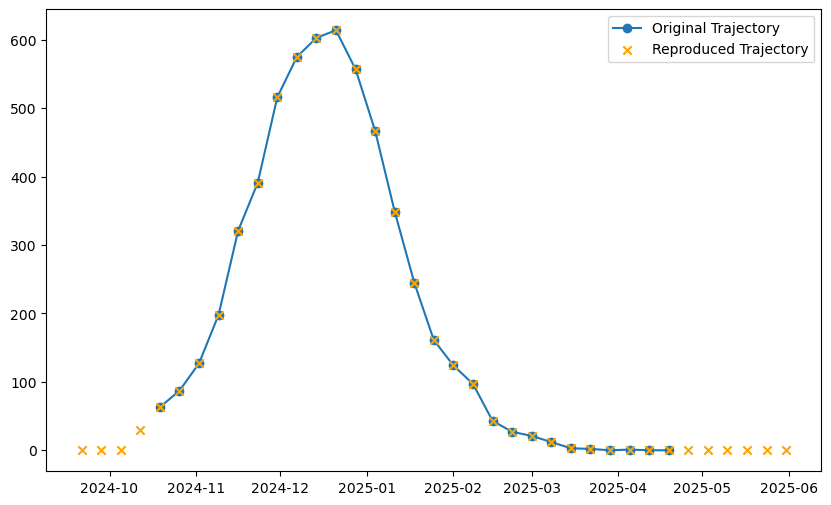

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
generation = 1
particle_index = 0
trajectory = cal_res.results.selected_trajectories[generation][particle_index]
ax.plot(trajectory['date'], trajectory['data'], marker='o', zorder=1, label = 'Original Trajectory')
# ax.scatter(reproduced['date'], reproduced['data'], marker='x', color='orange', zorder=2, label='Reproduced Trajectory')
hosp = reproduced_all[generation][particle_index]['Home_sev_to_Hosp_total'] + reproduced_all[generation][particle_index]["Home_sev_vax_to_Hosp_vax_total"]
ax.scatter(reproduced_all[generation][particle_index]['date'], hosp, marker='x', color='orange', zorder=2, label='Reproduced Trajectory')
ax.legend()

### Rerun trajectories with different scenario

In [12]:
vax_scen = pd.read_csv("../tutorials/data/vaccine_scenarios_2425_cd.csv")

# define different vaccination scenario
# here we stop all vaccinations after the cutoff date
vax_scen['Week_Ending_Sat'] = pd.to_datetime(vax_scen['Week_Ending_Sat'])

# define the cutoff date
cutoff_date = pd.Timestamp("2024-12-14")

# for each (Geography, Age) group, get the coverage value at cutoff_date
cutoff_values = (
    vax_scen.loc[vax_scen['Week_Ending_Sat'] == cutoff_date, ['Geography', 'Age', 'Coverage']]
    .set_index(['Geography', 'Age'])
    .to_dict()['Coverage']
)

# apply replacement
def replace_after_cutoff(group):
    key = (group.name[0], group.name[1])
    if key in cutoff_values:
        cutoff_value = cutoff_values[key]
        group.loc[group['Week_Ending_Sat'] > cutoff_date, 'Coverage'] = cutoff_value
    return group

vax_scen = vax_scen.groupby(['Geography', 'Age'], group_keys=False).apply(replace_after_cutoff)
vax_scen.to_csv("../tutorials/data/vaccine_scenarios_2425_cd_mod.csv")

/var/folders/rg/knmgp2gj4qdc26_lxdljzmd00000gn/T/ipykernel_24766/863950661.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vax_scen = vax_scen.groupby(['Geography', 'Age'], group_keys=False).apply(replace_after_cutoff)


In [13]:
simulation_functions = make_scenario_projection_simulate_wrappers(
    basemodel_config = basemodel_config,
    calibration_config = calibration_config,
    overrides = {"vaccination": {"scenario_data_path": "data/vaccine_scenarios_2425_cd_mod.csv"}}
)

In [14]:
reproduced_all_mod = reproduce_all_trajectories(
    calibrator=calibrators[0].calibrator,
    calibration_results=cal_res.results,
    simulation_function=simulation_functions[0],
    end_date=dt.date(2025, 5, 31)
) 

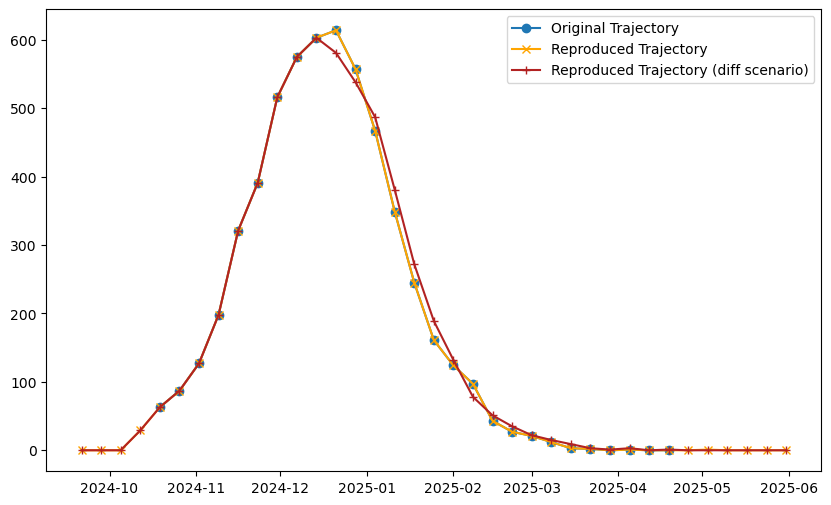

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
generation = 1
particle_index = 0
trajectory = cal_res.results.selected_trajectories[generation][particle_index]
ax.plot(trajectory['date'], trajectory['data'], marker='o', zorder=1, label = 'Original Trajectory')
hosp = reproduced_all[generation][particle_index]['Home_sev_to_Hosp_total'] + reproduced_all[generation][particle_index]["Home_sev_vax_to_Hosp_vax_total"]
ax.plot(reproduced_all[generation][particle_index]['date'], hosp, marker='x', color='orange', zorder=2, label='Reproduced Trajectory')
hosp_mod = reproduced_all_mod[generation][particle_index]['Home_sev_to_Hosp_total'] + reproduced_all_mod[generation][particle_index]["Home_sev_vax_to_Hosp_vax_total"]
ax.plot(reproduced_all_mod[generation][particle_index]['date'], hosp_mod, marker='+', color='firebrick', zorder=3, label='Reproduced Trajectory (diff scenario)')
ax.legend()